In [21]:
# import necessary libraries

# processing laryer
#https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/deepdive2/introduction_to_tensorflow/solutions/preprocessing_layers.ipynb
#http://localhost:8888/lab/tree/MyQuantFinProject/SMart-AI/_sample_tf_google/tfcolumn_basic_feat_eng.ipynb

# others
#https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/custom/custom-tabular-bq-managed-dataset.ipynb
#https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/deepdive2/introduction_to_tensorflow/solutions/int_logistic_regression.ipynb
#http://localhost:8888/lab/tree/MyQuantFinProject/SMart-AI/DemoDataTransform.ipynb

import math

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,DenseFeatures

from datetime import date, timedelta, datetime # Date Functions
import time


import os

import google.cloud.aiplatform as aip


from google.cloud import bigquery
from google.oauth2 import service_account
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# from google.cloud import aiplatform as vertex_ai
from tensorflow.python.keras.utils import data_utils

print(tf.__version__)
print(aip.__version__)

2.12.0
1.26.0


In [26]:
cateCols=['sla','product_type','brand','service_type','incident_type']
numbericCols=['open_to_close_hour','response_to_resolved_hour']
unusedCols=['severity_id','severity_name','label_binary_severity']

# cateCols=['sla','product_type','service_type','incident_type']
# numbericCols=['open_to_close_hour']
# unusedCols=['severity_id','severity_name','label_binary_severity','brand','response_to_resolved_hour']

labelCol='label_multi_severity'

#model_dir='model' # production
model_dir='gs://demo2-tf-incident-pongthorn/demo_model_tf' # demo


main_metric='accuracy'
main_objective=f'val_{main_metric}'


n_epochs=100
n_batch_size=16
nEarlyPatience=10


# df['label_multi_severity'] =df['severity_name'].map({'Cosmatic':0,'Minor': 1, "Major": 2, "Critical": 3}) 

In [27]:
# Load data from BigQuery
#projectId='smart-data-ml'
# credentials = service_account.Credentials.from_service_account_file(r'C:\Windows\smart-data-ml-91b6f6204773.json')
# client = bigquery.Client(credentials=credentials, project=projectId)

projectId='pongthorn'
client = bigquery.Client(project=projectId)
dataset_id='SMartML'

train_name='train_incident'
validation_name='validation_incident'
test_name='test_incident'

# Load Data

In [28]:
def load_ml_data(data_path):
 df=pd.read_csv(data_path)
 df =df.drop(columns=unusedCols)
 
 return df

def load_data_bq(sql:str):
 
 query_result=client.query(sql)
 df=query_result.to_dataframe()
 df =df.drop(columns=unusedCols)
  
 return df

In [29]:
train_table_id=f"{projectId}.{dataset_id}.{train_name}"
val_tabel_id=f"{projectId}.{dataset_id}.{validation_name}"
test_tabel_id=f"{projectId}.{dataset_id}.{test_name}"

train=load_data_bq(f"SELECT * FROM {train_table_id}")
val=load_data_bq(f"SELECT * FROM {val_tabel_id}")
test=load_data_bq(f"SELECT * FROM {test_tabel_id}")

# Load data from CSV File
# root_path='../../data'    
# train = load_ml_data(f"{root_path}/{train_name}.csv")
# val=load_ml_data(f"{root_path}/{validation_name}.csv")
# test =load_ml_data(f"{root_path}/{test_name}.csv")

print(train.shape)
print(val.shape)
print(test.shape)


(2731, 8)
(341, 8)
(342, 8)


In [30]:
labelList=list(train[labelCol].unique())
print("List All Label:" ,sorted(labelList))
nLabel=len(labelList)
print(f"No target label : {nLabel}")

print(train.info())
train.tail()

List All Label: [0, 1, 2, 3]
No target label : 4
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2731 entries, 0 to 2730
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   sla                        2731 non-null   object 
 1   product_type               2731 non-null   object 
 2   brand                      2731 non-null   object 
 3   service_type               2731 non-null   object 
 4   incident_type              2731 non-null   object 
 5   open_to_close_hour         2731 non-null   float64
 6   response_to_resolved_hour  2731 non-null   float64
 7   label_multi_severity       2731 non-null   Int64  
dtypes: Int64(1), float64(2), object(5)
memory usage: 173.5+ KB
None


,sla,product_type,brand,service_type,incident_type,open_to_close_hour,response_to_resolved_hour,label_multi_severity
2726,24x7 4Hrs Response Time,Security,Trend Micro,Request,General Incident,0.333333,0.333333,0
2727,24x7 6Hrs Resolution Time,Software,Trend Micro,Request,General Incident,0.883333,0.716667,0
2728,24x7 4Hrs Response Time,Security,Trend Micro,Request,OS / Firmware,16.666667,16.666667,0
2729,24x7 4Hrs Response Time,Software,Trend Micro,Request,General Incident,7.400000,7.283333,0
2730,24x7 6Hrs Resolution Time,Software,Trend Micro,Request,General Incident,5.483333,5.483333,0


In [31]:
def CalPctEachTargetClass(dfx,colSev,colPctSev):
    dfClassSummary=dfx.groupby([labelCol]).size().to_frame(colSev)
    dfClassSummary[colPctSev]= dfClassSummary[colSev]/dfClassSummary[colSev].sum() *100
    dfClassSummary=dfClassSummary.round(0)
    return dfClassSummary

pctDF1=CalPctEachTargetClass(train,'Train-No-Severity','Train-%-Severity')
pctDF2=CalPctEachTargetClass(val,'Val-No-Severity','Val-%-Severity')
pdcDF3=CalPctEachTargetClass(test,'Test-No-Severity','Test-%-Severity')
pctDF=pd.concat([pctDF1,pctDF2,pdcDF3],axis=1)

pctDF

,Train-No-Severity,Train-%-Severity,Val-No-Severity,Val-%-Severity,Test-No-Severity,Test-%-Severity
label_multi_severity,,,,,,
0,511,19.0,53,16.0,55,16.0
1,778,28.0,97,28.0,92,27.0
2,1341,49.0,180,53.0,181,53.0
3,101,4.0,11,3.0,14,4.0


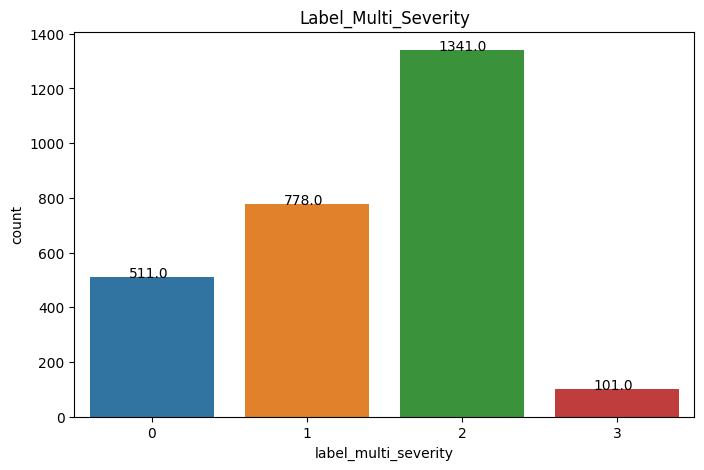

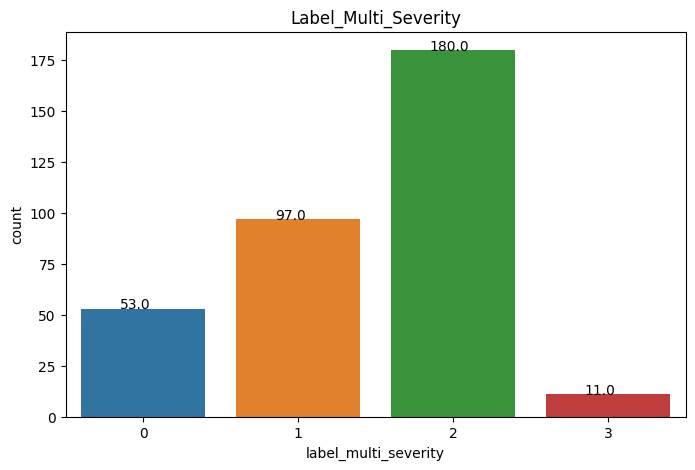

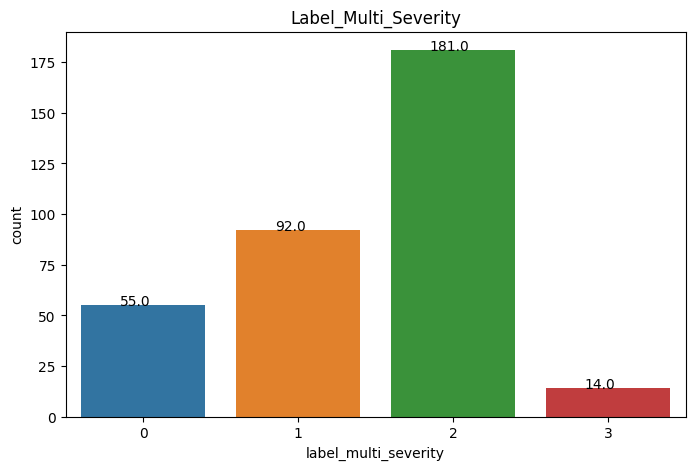

In [32]:
def plot_class(df):
    fig , ax = plt.subplots(figsize=(8,5))
    ax =sns.countplot(x=labelCol, data=df,)
    for p in ax.patches:
       ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
    plt.title(labelCol.title())
    plt.show()
    
plot_class(train)
plot_class(val)
plot_class(test)

# Process Data  Layer

In [33]:
def multiple_label_df_to_dataset(dataframe, shuffle=True, batch_size=32):
  features = dataframe.copy()
  labels = features.pop(labelCol)
  labels  = tf.keras.utils.to_categorical(labels, num_classes=nLabel)
    
  ds = tf.data.Dataset.from_tensor_slices(( dict(features), labels ))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(features))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds
     
     

In [34]:
print("Explore Data from Tensor before keras data processing")
batch_size = 1
train_ds =multiple_label_df_to_dataset(train, batch_size=batch_size)

[(train_features, label_batch)] = train_ds.take(1)
print("========Features==========")
print('Every feature:', list(train_features.keys()))
print('product_type:', train_features['product_type'])  # sample cate feature
print('open_to_close_hour:', train_features['open_to_close_hour'])  # sample numberic feature


Explore Data from Tensor before keras data processing
========Features==========
Every feature: ['sla', 'product_type', 'brand', 'service_type', 'incident_type', 'open_to_close_hour', 'response_to_resolved_hour']
product_type: tf.Tensor([b'Server'], shape=(1,), dtype=string)
open_to_close_hour: tf.Tensor([100.35], shape=(1,), dtype=float64)


2023-11-10 05:10:08.709684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [2731]
	 [[{{node Placeholder/_1}}]]
2023-11-10 05:10:08.711282: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype double and shape [2731]
	 [[{{node Placeholder/_4}}]]


In [35]:
print("========Labels==========")
print(f'{label_batch }')

========Labels==========
[[0. 0. 1. 0.]]


In [36]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for our feature.
  normalizer = preprocessing.Normalization(axis=None)

  # Prepare a Dataset that only yields our feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [37]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a StringLookup layer which will turn strings into integer indices
  if dtype == 'string':
    index = preprocessing.StringLookup(max_tokens=max_tokens)
  else:
    index = preprocessing.IntegerLookup(max_tokens=max_tokens)

  # Prepare a Dataset that only yields our feature
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Create a Discretization for our integer indices.
  encoder = preprocessing.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply one-hot encoding to our indices. The lambda function captures the
  # layer so we can use them, or include them in the functional model later.
  return lambda feature: encoder(index(feature))
     

In [38]:
hour_col = train_features['open_to_close_hour']
layer = get_normalization_layer('open_to_close_hour', train_ds)
layer(hour_col)

2023-11-10 05:10:08.805767: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [2731]
	 [[{{node Placeholder/_1}}]]
2023-11-10 05:10:08.807104: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [2731]
	 [[{{node Placeholder/_5}}]]


<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.05999922], dtype=float32)>

In [39]:
# total no type+unkonw
print(train['product_type'].unique())
type_col = train_features['product_type']
layer = get_category_encoding_layer('product_type', train_ds, 'string')
layer(type_col)

# onehot-encoding = 10 category+unknown=11 columnn

['Other' 'Printer' 'Storage' 'Software' 'Server' 'Access Point' 'Switch'
 'Hardware' 'Tape Library' 'Security' 'Service' 'Notebook' 'Firewall']


2023-11-10 05:10:14.102230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype string and shape [2731]
	 [[{{node Placeholder/_3}}]]
2023-11-10 05:10:14.103983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [2731]
	 [[{{node Placeholder/_5}}]]


<tf.Tensor: shape=(14,), dtype=float32, numpy=
array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>

In [40]:
batch_size =32
train_ds = multiple_label_df_to_dataset (train, batch_size=batch_size)
val_ds = multiple_label_df_to_dataset(val, batch_size=batch_size)
test_ds = multiple_label_df_to_dataset(test, batch_size=batch_size)
# for element in train_ds.as_numpy_iterator():
#     print(element)

# Data Transformation by Keras PreProcessing Layer 

In [41]:
all_inputs = []
encoded_features = []
numInputFeatToInitNodeUnit=0

# Numeric features.
for header in numbericCols:
  stat_data=train[header].describe()
  print(f"header: Mean={stat_data['mean']} and Std={stat_data['std']}")  
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)
    
numInputFeatToInitNodeUnit=numInputFeatToInitNodeUnit+len(numbericCols)
    
    # Categorical features encoded as string.
categorical_cols = cateCols
for header in categorical_cols:
  listCateItem=train[header].unique()
  noCateItem=len(listCateItem)
  numInputFeatToInitNodeUnit=numInputFeatToInitNodeUnit+noCateItem +1  # last 1 is unknow  
  print(f"{header} = {noCateItem} : {listCateItem}")

  print(header)  
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(header, train_ds, dtype='string')
                                        
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)


header: Mean=120.7417429512999 and Std=339.9325107996055


2023-11-10 05:10:16.760242: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype string and shape [2731]
	 [[{{node Placeholder/_3}}]]
2023-11-10 05:10:16.761700: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [2731]
	 [[{{node Placeholder/_2}}]]


header: Mean=92.4087208592701 and Std=292.40800375934094


2023-11-10 05:10:17.081614: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype double and shape [2731]
	 [[{{node Placeholder/_4}}]]
2023-11-10 05:10:17.082966: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_6' with dtype string and shape [2731]
	 [[{{node Placeholder/_6}}]]


sla = 7 : ['24x7 4Hrs Resolution Time' '24x7 4Hrs Response Time'
 '24x7 6Hrs Resolution Time' '8x5 4Hrs Response Time'
 '9x5 NBD 4Hrs Response Time' '24x7 6Hrs Response Time' 'Non MA']
sla


2023-11-10 05:10:17.393288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [2731]
	 [[{{node Placeholder/_1}}]]
2023-11-10 05:10:17.394559: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [2731]
	 [[{{node Placeholder/_1}}]]


product_type = 13 : ['Other' 'Printer' 'Storage' 'Software' 'Server' 'Access Point' 'Switch'
 'Hardware' 'Tape Library' 'Security' 'Service' 'Notebook' 'Firewall']
product_type


2023-11-10 05:10:17.617896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype float and shape [2731,4]
	 [[{{node Placeholder/_7}}]]
2023-11-10 05:10:17.619168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype double and shape [2731]
	 [[{{node Placeholder/_4}}]]


brand = 28 : ['F5' 'HP' 'EMC' 'HPE' 'IBM' 'YIP' 'DELL' 'QNAP' 'Cisco' 'SAPB1' 'Veeam'
 'NetApp' 'Oracle' 'VMWare' 'Zabbix' 'eUnite' 'Nutanix' 'Red Hat'
 'Veritas' 'Alfresco' 'Broadcom' 'Fortinet' 'Commvault' 'Microsoft'
 'Palo Alto' 'CIMCO-CMMS' 'CheckPoint' 'Trend Micro']
brand


2023-11-10 05:10:17.839206: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [2731]
	 [[{{node Placeholder/_1}}]]
2023-11-10 05:10:17.841137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype float and shape [2731,4]
	 [[{{node Placeholder/_7}}]]


service_type = 2 : ['Incident' 'Request']
service_type


2023-11-10 05:10:18.062230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2731]
	 [[{{node Placeholder/_0}}]]
2023-11-10 05:10:18.064494: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [2731]
	 [[{{node Placeholder/_2}}]]


incident_type = 21 : ['General Incident' 'Network Adapter Failure' 'Software'
 'Maintenance System' 'Hard Disk Drive Failure' 'Power Supply Failure'
 'Report' 'System Board Failure' 'Memory Failure' 'Network Card Failure'
 'Controller/Node Failure' 'Backup Failure' 'Upgrade Software'
 'CPU Failure' 'OS / Firmware' 'Configuration Change'
 'Cache Battery Failure' 'Other Failure' 'Network Cable Failure'
 'Battery Failure' 'Fan Failure']
incident_type


2023-11-10 05:10:18.291799: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype string and shape [2731]
	 [[{{node Placeholder/_3}}]]
2023-11-10 05:10:18.293213: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [2731]
	 [[{{node Placeholder/_1}}]]


In [42]:
print(f"Total column to initialize first node input: {numInputFeatToInitNodeUnit}")

Total column to initialize first node input: 78


# Build and Train and Eveluate and Plot Result

In [43]:
def plot_metrics(history,metric):
    plt.figure(figsize=(15,8))
    plt.title(metric)
    plt.plot(history.history[metric], label='train')
    plt.plot(history.history[f'val_{metric}'], label='validation')
    plt.legend()
    plt.show() 


In [44]:
# def build_model(num_units_1,num_units_layer2, dropout_rate):
def build_model(num_units_layer1, dropout_rate,learningRate,no_addtional_hidden_layer=1):
    
    all_features = tf.keras.layers.concatenate(encoded_features)
   
    x = tf.keras.layers.Dense(num_units_layer1, activation="relu")(all_features)# layer1
    
    if dropout_rate>0:
     print(f"Dropout: { dropout_rate}")
     x = tf.keras.layers.Dropout(dropout_rate)(x)
    
    # if no_addtional_hidden_layer>1:
    # for x  in range(0,1):  
    # x = tf.keras.layers.Dense(num_units_layer1, activation="relu")(x)  # layer2


    output = tf.keras.layers.Dense(nLabel,activation=tf.nn.softmax)(x)

    model = tf.keras.Model(all_inputs, output)
    
    if  learningRate==0:
        model.compile(optimizer='adam',
                      loss=tf.keras.losses.CategoricalCrossentropy(),metrics=[main_metric])
    else:
        print(f"LR: {learningRate}")
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learningRate),
                      loss=tf.keras.losses.CategoricalCrossentropy(),metrics=[main_metric])
    return model

# def build_wide_deep_model()
# METRICS = [
#       keras.metrics.BinaryAccuracy(name='accuracy'),
#       keras.metrics.Precision(name='precision'),
#       keras.metrics.Recall(name='recall'),
#       keras.metrics.AUC(name='auc'),
# ]

def train_model(model,x_epochs,x_batch_size):  
    # model.summary()
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=nEarlyPatience, verbose=1)  
    history =model.fit(train_ds, validation_data=val_ds,epochs=x_epochs,batch_size=x_batch_size,callbacks=[early_stopping])
    return history
  

# Test Run Model

In [46]:
print("1#Build model")

# smaller RL , longer , By doing this, you learn gradually rather than jumping around 
#A learning rate of 0.001 is the default (Adam)
#{'units': 32, 'Dropout_rate': 0.1}
#model=build_model(32,0.1,0.0001)
model=build_model(64,0.1,0.0001)
#model=build_model(numInputFeatToInitNodeUnit,0,0)
print(model.summary())
#model=build_model(128,0,0)


1#Build model
Dropout: 0.1
LR: 0.0001
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sla (InputLayer)               [(None, 1)]          0           []                               
                                                                                                  
 product_type (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 brand (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 service_type (InputLayer)      [(None, 1)]          0           []                               
                                                        

In [47]:
print("2#Train model")
history=train_model(model,n_epochs,n_batch_size)
print("=============================================================================")


2#Train model
Epoch 1/100


2023-11-10 05:10:40.029744: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_6' with dtype string and shape [2731]
	 [[{{node Placeholder/_6}}]]
2023-11-10 05:10:40.031291: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_6' with dtype string and shape [2731]
	 [[{{node Placeholder/_6}}]]


56/86 [==================>...........] - ETA: 0s - loss: 1.4051 - accuracy: 0.3069

2023-11-10 05:10:41.184172: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_6' with dtype string and shape [341]
	 [[{{node Placeholder/_6}}]]
2023-11-10 05:10:41.185676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [341]
	 [[{{node Placeholder/_1}}]]


86/86 [==============================] - 2s 7ms/step - loss: 1.3861 - accuracy: 0.3160 - val_loss: 1.3144 - val_accuracy: 0.3079
Epoch 2/100
86/86 [==============================] - 0s 2ms/step - loss: 1.2961 - accuracy: 0.3870 - val_loss: 1.2315 - val_accuracy: 0.4633
Epoch 3/100
86/86 [==============================] - 0s 2ms/step - loss: 1.2212 - accuracy: 0.4837 - val_loss: 1.1620 - val_accuracy: 0.5396
Epoch 4/100
86/86 [==============================] - 0s 2ms/step - loss: 1.1608 - accuracy: 0.5251 - val_loss: 1.1050 - val_accuracy: 0.5543
Epoch 5/100
86/86 [==============================] - 0s 2ms/step - loss: 1.1088 - accuracy: 0.5342 - val_loss: 1.0572 - val_accuracy: 0.5748
Epoch 6/100
86/86 [==============================] - 0s 2ms/step - loss: 1.0695 - accuracy: 0.5317 - val_loss: 1.0174 - val_accuracy: 0.5748
Epoch 7/100
86/86 [==============================] - 0s 2ms/step - loss: 1.0317 - accuracy: 0.5463 - val_loss: 0.9836 - val_accuracy: 0.5924
Epoch 8/100
86/86 [======

In [48]:
print("3#Evaluate model")

loss_val, accuracy_val = model.evaluate(val_ds)
print(f"Average Loss - Accuracy on Eveluation {loss_val} -{accuracy_val}")

loss_test, accuracy_test = model.evaluate(test_ds)
print(f"Average Loss - Accuracy on Test {loss_test} -{accuracy_test}")

print("=============================================================================")


# production data set to 12MAr23
# 7/7 [==============================] - 0s 2ms/step - loss: 0.6655 - accuracy: 0.7689
# Average Loss - Accuracy on Eveluation 0.6654592752456665 -0.7688679099082947
# 7/7 [==============================] - 0s 2ms/step - loss: 0.6977 - accuracy: 0.7358
# Average Loss - Accuracy on Test 0.6977102160453796 -0.7358490824699402


# demo set to 04 April23
# 8/8 [==============================] - 0s 2ms/step - loss: 0.7334 - accuracy: 0.7621
# Average Loss - Accuracy on Eveluation 0.7333917617797852 -0.7621145248413086
# 8/8 [==============================] - 0s 3ms/step - loss: 0.7452 - accuracy: 0.6740
# Average Loss - Accuracy on Test 0.745168149471283 -0.6740087866783142
# ============================================================================

3#Evaluate model
11/11 [==============================] - 0s 2ms/step - loss: 0.7064 - accuracy: 0.7185
Average Loss - Accuracy on Eveluation 0.7063832879066467 -0.7184750437736511
11/11 [==============================] - 0s 2ms/step - loss: 0.6786 - accuracy: 0.7193
Average Loss - Accuracy on Test 0.678640604019165 -0.719298243522644


2023-11-10 05:11:15.239717: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype double and shape [342]
	 [[{{node Placeholder/_2}}]]
2023-11-10 05:11:15.241407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype float and shape [342,4]
	 [[{{node Placeholder/_7}}]]


4#Explore Result model


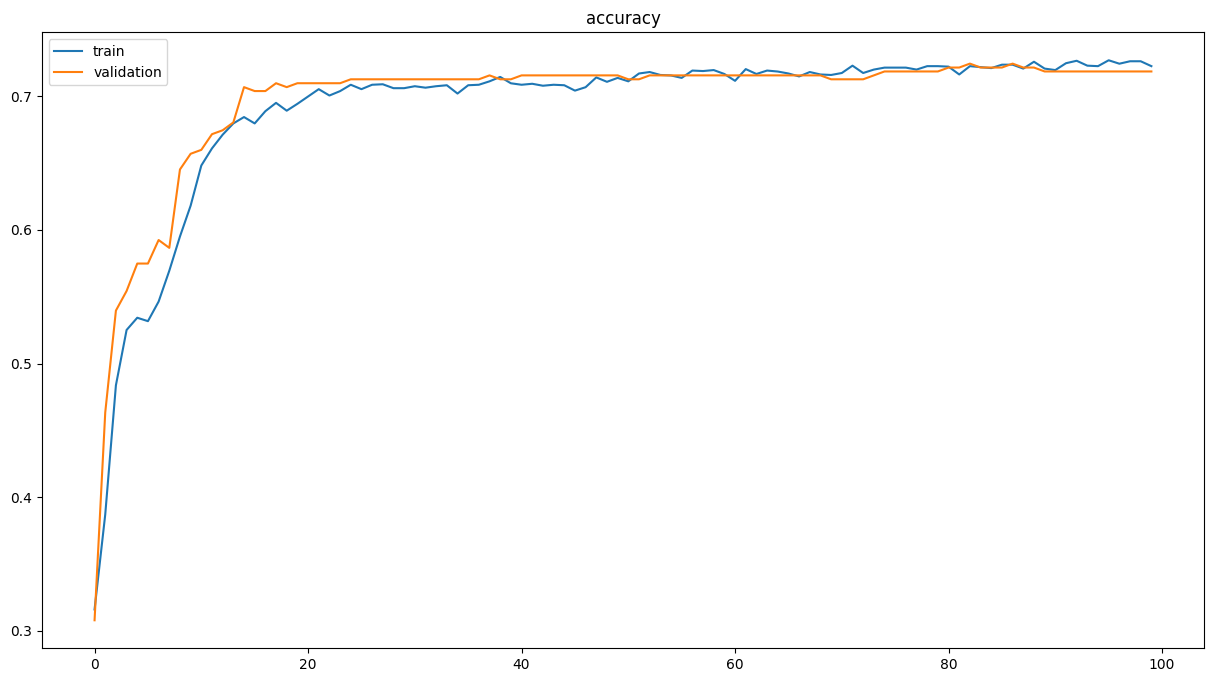

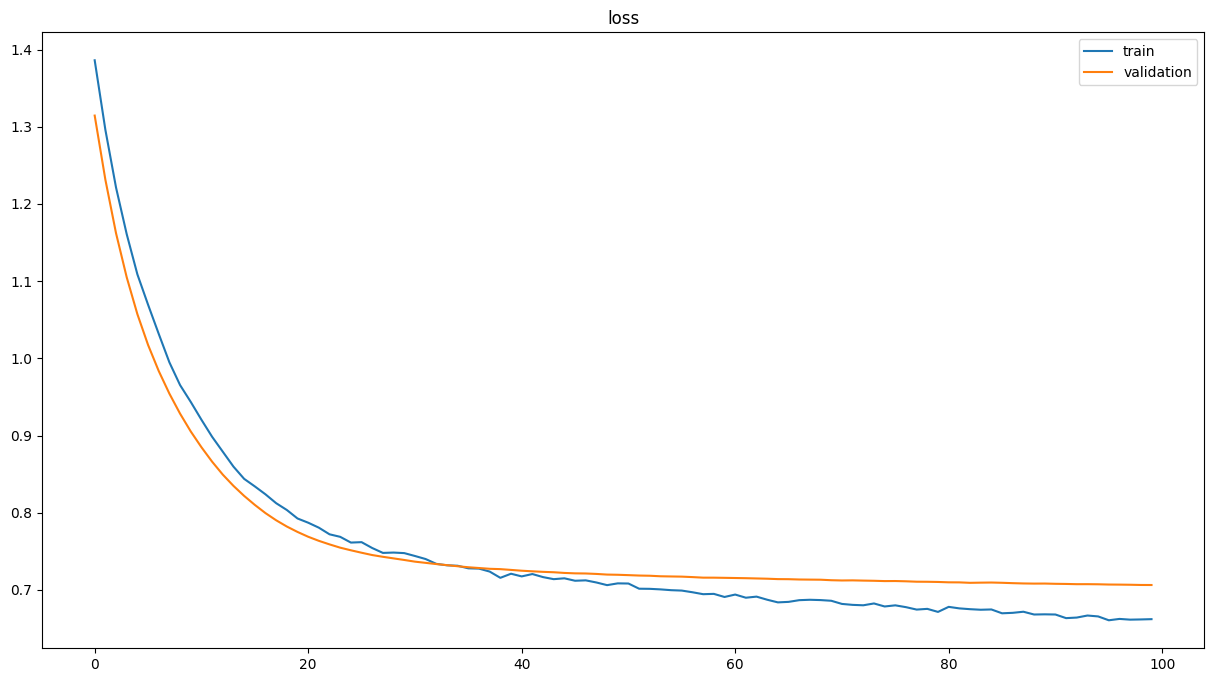

In [49]:
print("4#Explore Result model")
plot_metrics(history,main_metric)
plot_metrics(history,"loss")


# Save Model

In [50]:
model.save(model_dir)


2023-11-10 05:11:16.386504: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype int64 and shape [?,1]
	 [[{{node inputs}}]]
2023-11-10 05:11:16.393920: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype int64 and shape [?,1]
	 [[{{node inputs}}]]
2023-11-10 05:11:16.400659: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype int64 and shape [?,1]
	 [[{{node inputs}}]]
2023-11-10 05:11:16.40

INFO:tensorflow:Assets written to: gs://demo2-tf-incident-pongthorn/demo_model_tf/assets


INFO:tensorflow:Assets written to: gs://demo2-tf-incident-pongthorn/demo_model_tf/assets


# Try Prediction

In [51]:
#label_multi_severity

local_model= tf.keras.models.load_model(model_dir)

sample={"sla":"24x7 4Hrs Response Time",
        "product_type":"Server",
        "brand":"VMWare",                
        "service_type":"Incident",
        "incident_type":"General Incident",
        "open_to_close_hour":12,
        "response_to_resolved_hour":8.500000 \
       }

print(sample)
              
print("===============================================================================================================")    
print("convert pain data to serdor as input to predict")    
input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
print(input_dict)

predictionList = local_model.predict(input_dict)
print(predictionList)

prob = tf.nn.softmax(predictionList[0])
print(f"{(100 * prob)} % at {np.argmax(prob, axis=0)} as Severity") 


{'sla': '24x7 4Hrs Response Time', 'product_type': 'Server', 'brand': 'VMWare', 'service_type': 'Incident', 'incident_type': 'General Incident', 'open_to_close_hour': 12, 'response_to_resolved_hour': 8.5}
convert pain data to serdor as input to predict
{'sla': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'24x7 4Hrs Response Time'], dtype=object)>, 'product_type': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Server'], dtype=object)>, 'brand': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'VMWare'], dtype=object)>, 'service_type': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Incident'], dtype=object)>, 'incident_type': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'General Incident'], dtype=object)>, 'open_to_close_hour': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([12], dtype=int32)>, 'response_to_resolved_hour': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([8.5], dtype=float32)>}
1/1 [==============================] - 0s 265ms/step
[[0.0403

# Copy Model From Local To GCS

In [52]:
# # #https://codelabs.developers.google.com/codelabs/fraud-detection-ai-explanations?hl=en#6
# # press_y3=input(f"Press y=True to save model to Google Cloud storage : ") 
# # if press_y3.lower()=='y':
# MODEL_BUCKET = 'gs://tf1-incident-smart-ml-yip'

# # # # !gsutil mb -l $REGION $MODEL_BUCKET
# # !gsutil -m cp -r ./$model_dir/* $MODEL_BUCKET/demo_model
# !gsutil -m cp -r ./$model_dir/* $MODEL_BUCKET/model
# #!gsutil -m cp -r ./$explain_meta_model_dir/* $MODEL_BUCKET/demo_model_explain_meta
# # else:
# #  quite()
